**Question 1**

Setting up the process

In [3]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=69420)     # set up random number generator with fixed seed for reproducability

Generating the spikes, uses the exponential distribution to determine the time to the next spike. Could be optmised, calculating both the homo and inhomo case while only returning one is silly

In [4]:
def SpikeGeneration(timeStop = 1, homo = True, refractory = 0.05, expected = 35):
    # refractory is minimum time between spikes for the inhomogeneous case
    # expected is lambda in the exponential distribution
    spikesHomo = []
    spikesInhomo = []
    timeTotal = 0
    while timeTotal < timeStop:
        time = rng.exponential(1/expected)
        timeTotal += time
        if timeTotal > timeStop:
            break
    
        spikesHomo.append(timeTotal)
        if len(spikesInhomo) == 0:
            spikesInhomo.append(timeTotal)
        # what are the odds that no spikes occur over the period?
        # High apparently
        elif timeTotal - spikesInhomo[-1] > refractory:
            spikesInhomo.append(timeTotal)

    if homo == True: return spikesHomo
    elif homo == False: return spikesInhomo


Calculating the ISI coefficient, $C_{ISI} = \frac{\sigma}{\mu}$

In [5]:
def ISICoeff(spikes):
    spikeISI = []
    for spike in range (0, len(spikes)):
        if spike == 0: pass
        else:
            spikeISI.append(spikes[spike] - spikes[spike - 1])

    return np.std(spikeISI) / np.mean(spikeISI)

Calculating the Inter Spike Interval coefficient for the two created spike trains

In [6]:
spikesHomo = SpikeGeneration()
spikesInhomo = SpikeGeneration(homo = False)
cHomo = ISICoeff(spikesHomo)
cInhomo = ISICoeff(spikesInhomo)

In [7]:
print(cHomo)
print(cInhomo)
# cHomo should be ~1, I assume cInhomo should be less than

0.8258735087580551
0.33422870379391895


Calculating the fano factor for a given set of spike trains, $F=\frac{\sigma^2}{\mu}$

In [8]:
def FanoFactor(spikes):
    # spikes should be a 2D array with D-1 being the differing runs & D-2 the spikes in those runs
    # the function calculates the spike counts for the runs and returns the fano factor
    # !!!!TAKES THE VECTOR OF SPIKE TIMES!!!! NOT SPIKES THEMSELVES
    spikeCounts = [len(run) for run in spikes]     # python indexes from 0
    return np.var(spikeCounts) / np.mean(spikeCounts)

Calculating the fano factor for the homogeneous case, the inhomogeneous case needs to be run over multiple $\Delta t$ so is done seperately 

In [9]:
runCount = 10
spikesHomo = []
for run in range(0, runCount):
    spikesHomo.append(SpikeGeneration())

print(FanoFactor(spikesHomo))

0.4837209302325582


Calculating the fano factor for the inhomogeneous case for $\Delta t$ = 10ms, 50ms, 100ms

In [10]:
times = [0.01, 0.05, 0.1]
spikesInhomo = []
for time in times:
    spikesTemp = []
    for run in range(0, runCount):
        spikesTemp.append(SpikeGeneration(timeStop = time, homo = False))

    spikesInhomo.append(spikesTemp)

fanoFactor = []
for spikes in spikesInhomo:
    fanoFactor.append(FanoFactor(spikes))

print(fanoFactor)

[0.6000000000000001, 0.19999999999999998, 0.31428571428571433]


Part iv, gotta plot the ISI and fano factor for $\Delta t$ = 100ms with $refractory \in [0ms, 28ms]$

C:\Users\Kate\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Kate\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Kate\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Kate\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Kate\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Refractory period (ms)')

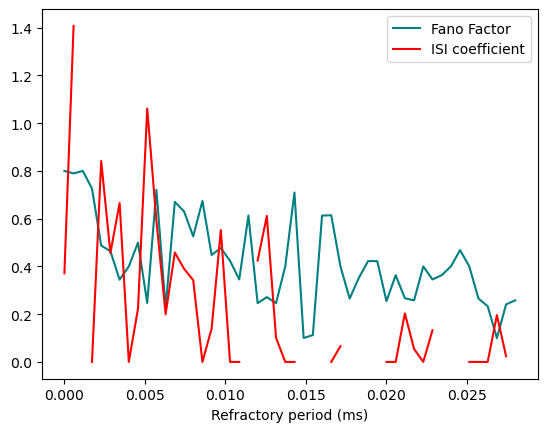

In [11]:
# 0ms refractory is special case, where the process in homogeneous to avoid floating point errors
ISI = []
fano = []
spikesTemp = []
refractory = np.linspace(0, 0.028)
ISI.append(ISICoeff(SpikeGeneration(timeStop = 0.1)))
for run in range(0, runCount):
    spikesTemp.append(SpikeGeneration(timeStop = 0.1))

fano.append(FanoFactor(spikesTemp))

# inhomogeneous process
for refracTime in refractory[1:]:
    ISI.append(ISICoeff(SpikeGeneration(timeStop = 0.1, refractory = refracTime, homo=False)))
    spikesTemp = []
    for run in range(0, runCount):
        spikesTemp.append(SpikeGeneration(timeStop = 0.1, refractory = refracTime, homo=False))

    fano.append(FanoFactor(spikesTemp))


fig, ax = plt.subplots()

ax.plot(refractory, fano, color='teal', label='Fano Factor')
ax.plot(refractory, ISI, color='red', label='ISI coefficient')
ax.legend()
ax.set_xlabel('Refractory period (ms)')

# missing values are due to divsion by zero, can be fixed by increasing delta t but the question asks for it to be 100ms

<b>Question 2</b>

In [12]:
# reading and converting file to numbers
with open('rho.dat', 'r') as data:
    spikes = [line.rsplit() for line in data]

# this line is so dumb
spikes = [int(spike[0]) for spike in spikes]

# convert the spikes into a time series
deltaT = 0.002

# this line is dumber no way this is what im supposed to be doing
spikeTimes = [deltaT*spikeCount*spike for spikeCount, spike in zip(range(0, len(spikes)), spikes) if deltaT*spikeCount*spike != 0]

ISI = ISICoeff(spikeTimes)
print(ISI)

# bin size of 1 is a special case
spikesBinned1 = [[spike] if spike else [] for spike in spikes]

# this is a bit fucked and im not sure why it works but i went through 6 different comprehension attempts
binSizes = [5, 25, 50]
spikesBinned = []
for binSize in binSizes:
    spikesTemp = []
    # stole these 2 lines from stackoverflow
    for i in range(0, len(spikes), binSize):
        spikesTemp.append(spikes[i:i + binSize])

    # removes any instance of no spike from the list so that using len() can count the spikes
    # this is the reason bin size of 1 is a special case
    for x in spikesTemp:
        while x.count(0):
            x.remove(0)
    spikesBinned.append(spikesTemp)

# actually doing the fano factor, again bin size 1 is treated seperately
fano1 = FanoFactor(spikesBinned1)
fano = [FanoFactor(spike) for spike in spikesBinned]
print(fano1)
print(fano)

2.0085523370640965
0.9106650000000001
[1.117680142627936, 2.9297562848640877, 4.102959520344769]


The ISI coefficient is higher than expected for a poisson process, suggesting this spike train is more irregular than a poisson process. The fano factor for bin size 2ms was only slightly lower than 1, suggesting more regularity than a poisson process but this may be a statistical error. The higher the bin size the higher the fano factor with bin size >=5ms having a fano factor higher than would be expected for a poisson process, and thus more regular.

<b> Question 3 </b>
Using the leaky integrate and fire neuron from coursework 3:

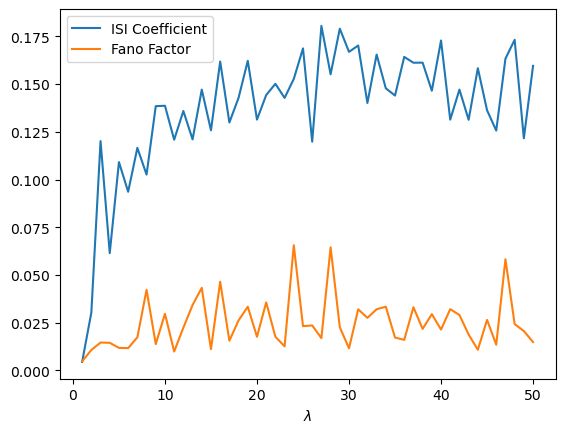

In [13]:
from math import e
from random import uniform

def Leaky(f=35, Es = 0):
    # Es:
    # synapse strength, -ve is inhibatory, +ve is excitatory, should be ~0 ms
    # f:
    # frequency pre-synaptic neuron fires at
    m = 10 ** -3    # milli prefix
    M = 10 ** 6     # mega prefix
    n = 10 ** -9    # nano prefix
    
    h = 1 * m       # time step, delta t in euler approx.
    pCrit = h*f     # probability of the neuron firing in each time step
    
    tau = 20 * m    # time constant
    vThreshold = -54 * m  # voltage threshold spikes occur at
    El = -70 * m     # leak potential
    R = 10 * M      # membrane resistance
    vReset = -80 * m      # reset voltage
    Ie = 1.8 * n     # electode (/synaptic) input current
    
    # synaptic stuff i didn't comment it in the original code so i dont know what it means
    p = 0.5
    tauS = 10 * m
    Rg = 0.15
    
    # Rm is moved into It function to prevent floating point errors
    It = lambda v, t, s: R * Ie + Rg * s * (Es - v)
    
    s = lambda t: e ** (-t/tauS)
    
    dv_dt = lambda v, t, s: (El - v + It(v, t, s)) / tau
    
    # euler approx. to V and s
    EulerDv = lambda v, h, f, t, s: v + h * f(v, t, s)
    
    V0 = [uniform(vReset, vThreshold)]
    t = [0]
    # s* is last time the neuron fired
    s0 = 0

    spikesPre = [0]
    spikesPost = []

    while t[-1] < 1:
        # calculate voltage of the neurons, value may change if there is a spike
        VTemp0 = EulerDv(V0[-1], h, dv_dt, t[-1], s(t[-1]-spikesPre[-1]))
    
        if rng.uniform()<=pCrit:
            spikesPre.append(t[-1])
            
    
        if VTemp0 < vThreshold:
            V0.append(VTemp0)
        elif VTemp0 >= vThreshold:
            V0.append(vReset)
            spikesPost.append(t[-1])
    
        t.append(t[-1]+h)

    return spikesPost

freqs = np.linspace(1, 50)
ISI = []
fano = []

for freq in freqs:
    spikes = []
    # run the spike generation multiple times for the fano factor
    for q in range(0, 10):
        spikes.append(Leaky(f=freq))
    ISI.append(ISICoeff(spikes[0]))
    fano.append(FanoFactor(spikes))
    

fig, ax = plt.subplots()
ax.plot(freqs, ISI, label='ISI Coefficient')
ax.plot(freqs, fano, label='Fano Factor')
ax.set_xlabel(r'$\lambda$')
ax.legend()

Changing the expected amount of pre-synaptic neuron spikes has no effect on the fano factor and only increases the ISI coefficient a small amount.
The neuron fires much more regularly than would be expected for a poisson process.

Text(0.5, 0, 'Reversal Potential')

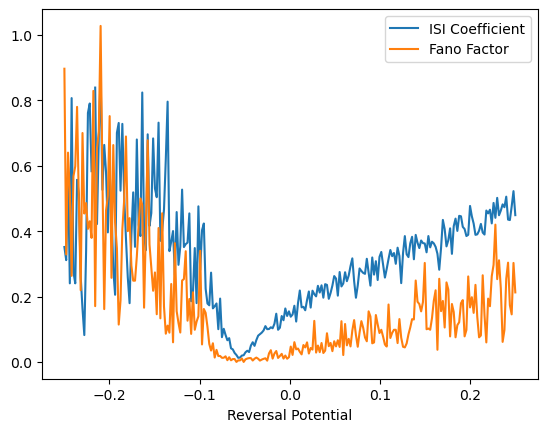

In [14]:
Es = np.linspace(-0.25, 0.25, 250)
ISI = []
fano = []
for E in Es:
    spikes = []
    for q in range(0, 10):
        spikes.append(Leaky(Es=E))
    ISI.append(ISICoeff(spikes[0]))
    fano.append(FanoFactor(spikes))

fig, ax = plt.subplots()
ax.plot(Es, ISI, label='ISI Coefficient')
ax.plot(Es, fano, label='Fano Factor')
ax.legend()
ax.set_xlabel('Reversal Potential')
    

The ISI coefficient and fano factor are at a minimum when the reversal potential is ~-0.05. It increases drastically as the reversal potential decreases, while increasing a little as reversal potential increases. For all values tested the neuron fires more regularly than would be expected for a poisson process.

Question 4
Spike Triggered Average
$s(\tau)=\frac{1}{n}\sum^n_{i=1}x(t_i-\tau)$

600000
600000
53601


Text(0, 0.5, 'STA')

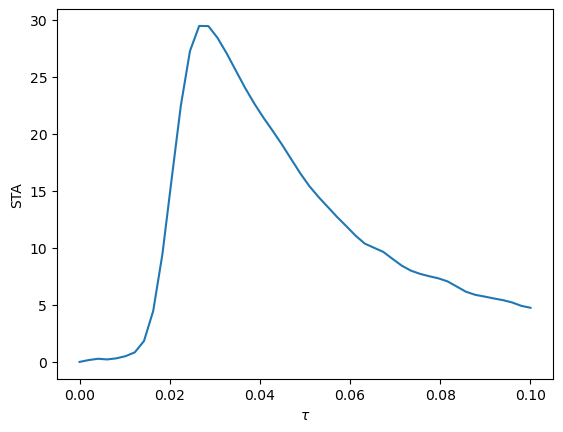

In [25]:
# stimulus data
with open('stim.dat', 'r') as file:
    stim = [float(line.rsplit()[0]) for line in file]

# spike data
with open('rho.dat', 'r') as data:
    spikes = [int(line.rsplit()[0]) for line in data]

deltaT = 0.002
# stupid line again for converting spikes into spike times
spikeTimes = [deltaT*spikeCount*spike for spikeCount, spike in zip(range(0, len(spikes)), spikes) if deltaT*spikeCount*spike != 0]

def sta(spikes, stimulus, tau, deltaT):
    # returns the sta for a given set of SPIKE TIMES, stimulus, tau, and window spikes were measured over
    # generally deltaT is constant for a given set of data
    stimTemp = []
    for spike in spikes[int(tau/deltaT):]:
        # int(*) converts the time back into the list index
        stimTemp.append(stimulus[int((spike-tau)/deltaT)])
    return ((1/len(spikeTimes)) * sum(stimTemp))

# s = sta(spikeTimes, stim, tau, deltaT)

taus = np.linspace(0, 0.1)
s = []
for tau in taus:
    s.append(sta(spikeTimes, stim, tau, deltaT))

fig, ax = plt.subplots()

ax.plot(taus, s)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('STA')

Question 5,
following on from Q4

In [16]:
intervals = [0.002, 0.004, 0.01, 0.02, 0.05]
indexes = [1, 2, 5, 10, 25]     # indexing difference for the intervals, 0.002ms is 1 sample behind sample 0

tau = 0.1

# case where spikes are not necessarily adjacent

spikePairsN = []     # the first spike from a spike pair time for STA calculation

for interval, index in zip(intervals, indexes):
    spikePairsTemp = []
    for spike in range(0, len(spikeTimes)-index):
        # checks if any spikes are an interval apart
        if spikeTimes[spike]+interval in spikeTimes[spike+1:]:
            spikePairsTemp.append(spikeTimes[spike])
    spikePairsN.append(spikePairsTemp)



In [17]:
# case where the spikes are adjacent

spikePairsA = []

for interval, index in zip(intervals, indexes):
    spikePairsTemp = []
    for spike in range(0, len(spikeTimes)-index):
        # checks if only the next spike is an interval apart
        if spikeTimes[spike]+interval == spikeTimes[spike+1]:
            spikePairsTemp.append(spikeTimes[spike])
    spikePairsA.append(spikePairsTemp)

Text(0, 0.5, 'STA')

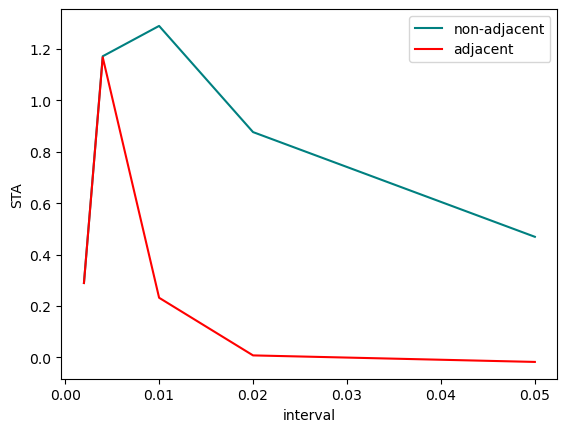

In [18]:

sN, sA = [], []
for (spikesN, spikesA) in zip(spikePairsN, spikePairsA):
    sN.append(sta(spikesN, stim, tau, deltaT))
    sA.append(sta(spikesA, stim, tau, deltaT))

fig, ax = plt.subplots()
ax.plot(intervals, sN, color='teal', label='non-adjacent')
ax.plot(intervals, sA, color='red', label='adjacent')
ax.legend()
ax.set_xlabel('interval')
ax.set_ylabel('STA')

STA for adjacently firing neurons is considerabley lower, hitting ~0 with an interval of 0.05 seconds. For 0.002 all spikes seperated by that interval must be adjacent as that is the resolution of the data. Something something the refractory period does stuff.

<b> Question 6 <b>

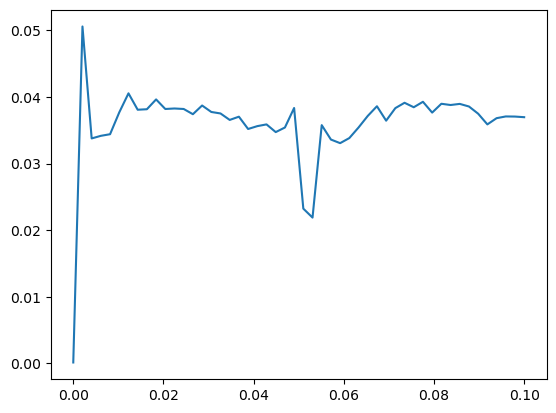

In [40]:
def Leaky(stim):
    # stimulus data from the stim.dat file provided in Q6

    m = 10 ** -3    # milli prefix
    M = 10 ** 6     # mega prefix
    n = 10 ** -9    # nano prefix
    
    h = 2 * m       # time step, delta t in euler approx.
    
    tau = 20 * m    # time constant
    vThreshold = -54 * m  # voltage threshold spikes occur at
    El = -70 * m     # leak potential
    R = 10 * M      # membrane resistance
    vReset = -80 * m      # reset voltage
    Ie = 1.8 * n     # electode (/synaptic) input current
    
    # synaptic stuff i didn't comment it in the original code so i dont know what it means
    p = 0.5
    tauS = 10 * m
    Rg = 0.15

    Es = -80 * m
    
    # Rm is moved into It function to prevent floating point errors
    It = lambda v, t, s: R * Ie + Rg * s * (Es - v)
    

    dv_dt = lambda v, t, s: (El - v + It(v, t, s)) / tau
    
    # euler approx. to V and s
    EulerDv = lambda v, h, f, t, s: v + h * f(v, t, s)
    
    V0 = [uniform(vReset, vThreshold)]
    t = [0]
    # s* is last time the neuron fired
    s0 = 0

    spikesPost = []

    for t in range(0, len(stim)):
        # calculate voltage of the neurons, value may change if there is a spike
        VTemp0 = EulerDv(V0[-1], h, dv_dt, t*h, stim[t])

        if VTemp0 < vThreshold:
            V0.append(VTemp0)
        elif VTemp0 >= vThreshold:
            V0.append(vReset)
            spikesPost.append(t*h)
    


    return spikesPost


# spike data importing
with open('rho.dat', 'r') as data:
    stim = [int(line.rsplit()[0]) for line in data]

spikes = Leaky(stim)
STA = []
taus = np.linspace(0, 0.1)
for tau in taus:
    STA.append(sta(spikes, stim, tau, deltaT))

fig, ax = plt.subplots()
ax.plot(taus, STA)

I have no idea what this graph is supposed to look like, if I'm supposed to vary $\tau$ or something else. I don't know what it means and changing Es massively changes what is looks like. Comparing this graph to the one above mean something probably I don't care anymore